In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam
from tqdm import tqdm
from torchvision.transforms import Lambda
# torch.nn.Module
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [2]:
class MNISTDataLoader:
    def __init__(self , shuffle=True):
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)), Lambda(lambda x: torch.flatten(x))])
        self.train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        self.test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        self.shuffle = shuffle

    def train_loader(self,batch_size ):
        return DataLoader(self.train_dataset, batch_size=batch_size, shuffle=self.shuffle)

    def test_loader(self,batch_size):
        return DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)



In [3]:
data_loader = MNISTDataLoader()
train_data= data_loader.train_loader(50000)
test_data= data_loader.test_loader(10000)


(آ)تعریف ماسک مناسب :

a sample of mask:


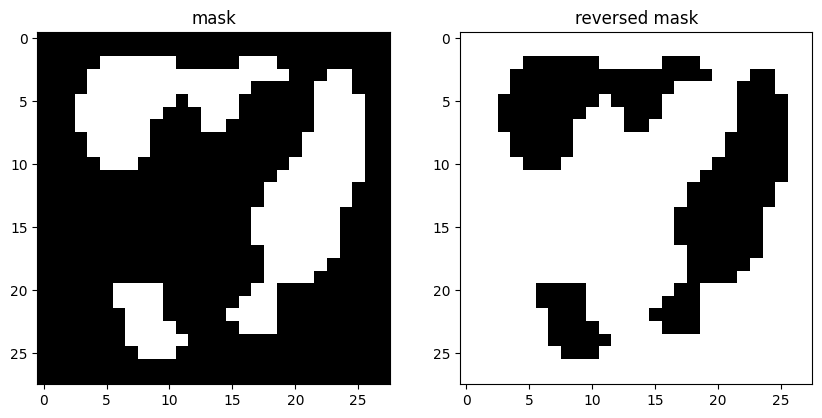

In [4]:
def create_mask():
    # random bit image
    mask = torch.randint(low=0,high= 2,size=[1, 1, 28, 28]).float()
    filter = torch.tensor([1/4, 1/2, 1/4])

    # Blur the image repeatedly
    for _ in range(8):  # Adjust the range as needed
        filter= filter.view(1, 1, -1, 1)
        mask = F.conv2d(mask, filter, padding=(1, 0))
        filter= filter.view(1, 1, 1, -1)
        mask = F.conv2d(mask, filter, padding=(0,1))
    mask = (mask > 0.5).float()
    return mask

Temp_mask = create_mask()
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(Temp_mask.reshape(28,28),'gray')
axs[0].set_title('mask')
axs[1].imshow((1-Temp_mask).reshape(28,28),'gray')
axs[1].set_title('reversed mask')
print('a sample of mask:')


an instance of create_mask function's output:


(ب)تولید داده :

an example of negative data


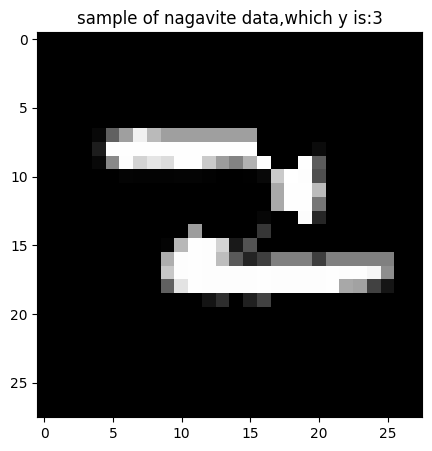

In [5]:
def random_num(excluded_number):
    while True:
        number = torch.randint(low=0,high= 10, size=(1,)).item()
        if isinstance(excluded_number, list):
            if number not in excluded_number:
                return number


def Hybrid_data(x,y):
    number_of_x = x.shape[0]
    # initial the negative x as shape as input x
    neg_x = torch.zeros_like(x)

    for i in range(number_of_x):
        rand_index1 = random_num([y[i]])
        rand_index2= random_num([y[i] ,rand_index1])
        img1 = x[rand_index1].reshape(28,28)
        img2 = x[rand_index2].reshape(28,28)
        mask = create_mask()
        img1 , img2 , mask = img1.to(device) , img2.to(device) , mask.to(device)
        reversed_mask = 1 - mask
        neg_d = (mask * img1) + (reversed_mask * img2)
        neg_x[i] = neg_d.reshape(784)


    return neg_x

# show a negative data
Temp_x , Temp_y = next(iter(train_data))
neg_data = Hybrid_data(Temp_x,Temp_y)
idx = 100
plt.figure(figsize=(5, 5))
plt.imshow(neg_data[idx].reshape(28,28).numpy(), 'gray')
plt.title(f'sample of nagavite data,which y is:{Temp_y[idx]}')
print('an example of negative data')

(ج)پیاده سازی شبکه

In [13]:
def Goodness(g_pos , g_neg , threshold):
    g_pos = g_pos.pow(2).mean(1)
    g_neg = g_neg.pow(2).mean(1)
    loss = torch.log1p( torch.exp(torch.cat([-g_pos + threshold, g_neg - threshold]))).mean()
    return loss

In [12]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features, lr=0.03 , threshold = 2.0 ,num_epochs = 1000,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr = lr)
        self.threshold = threshold
        self.num_epochs = num_epochs

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        Linear_relu_out = self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))
        return Linear_relu_out

    def train(self, x_pos, x_neg):
        for i in tqdm(range(self.num_epochs)):
            # compute the mean squared output of the model for
            # positive samples (x_pos) and negative samples (x_neg)
            # print('x_pos:',x_pos.shape)
            g_pos = self.forward(x_pos)
            g_neg = self.forward(x_neg)
            # print('goodness_pos:',goodness_pos.shape)
            # This loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold
            loss = Goodness(g_pos , g_neg , self.threshold)

            # clear the gradients of all optimized torch.Tensors
            self.opt.zero_grad()
            # gradients of the loss with respect to the model parameters
            loss.backward()
            #  update the parameters of the model based on the gradients
            self.opt.step()
            # detach() function is used to prevent further computation of gradients
            next_x_pos = self.forward(x_pos).detach()
            next_x_neg = self.forward(x_neg).detach()

        return next_x_pos, next_x_neg


In [14]:
class Net():
    def __init__(self, dims):
        self.layers = []
        for indx in range(len(dims) - 1):
            self.layers += [Layer(dims[indx ], dims[indx + 1]).cuda()]

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = x.clone()
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)

In [8]:
net = Net([784, 500, 500])
x_train = iter(train_data)
for x_data in x_train:
    x_t , y_t = x_data
    x_t , y_t = x_t.to(device) , y_t.to(device)
    # make negative data
    x_neg = Hybrid_data(x_t,y_t)
    net.train(x_t, x_neg)
    # train the network


training layer 0 ...


100%|██████████| 1000/1000 [00:58<00:00, 17.00it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:41<00:00, 24.14it/s]


training layer 0 ...


100%|██████████| 1000/1000 [00:13<00:00, 74.88it/s]


training layer 1 ...


100%|██████████| 1000/1000 [00:08<00:00, 115.94it/s]


I get very low accuracy on my model

In [9]:
x_train = iter(train_data)
First = True
for x_data in x_train:
    x_t , y_t = x_data
    x_t , y_t = x_t.to(device) , y_t.to(device)
    if First:
        accuracy = (net.predict(x_t) == y_t)
        First = False
    else:
        accuracy = torch.cat((accuracy , (net.predict(x_t) == y_t)), dim=0)

accuracy = accuracy.float().mean().item()
print('train accuracy:',accuracy)

train accuracy: 0.09871666878461838


In [10]:
x_test = iter(test_data)
First = True
for x_data in x_test:
    x_t , y_t = x_data
    x_t , y_t = x_t.to(device) , y_t.to(device)
    if First:
        accuracy = (net.predict(x_t) == y_t)
        First = False
    else:
        accuracy = torch.cat((accuracy , (net.predict(x_t) == y_t)), dim=0)

accuracy = accuracy.float().mean().item()
print('test accuracy:',accuracy)

test accuracy: 0.09799999743700027


there is a Github example that implenemt this problem, but becuase I didn't understand it very well, I preferred my code with low accuracy :/
https://github.com/ghadialhajj/FF_unsupervised